<a href="https://colab.research.google.com/github/saharsh94/facekeypointdetection/blob/main/facedetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# librery


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
import pandas as pd
import cv2, os
import seaborn as sns
import matplotlib.pyplot as plt
from math import sin, cos, pi
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, callbacks, utils, applications, optimizers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, Flatten,Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, load_model,Sequential
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from matplotlib.pyplot import imshow

%matplotlib inline

#data

In [ ]:

print("\nExtracting .zip dataset files to working directory ...")
!unzip -u ../content/test.zip
!unzip -u ../content/training.zip

print("\nCurrent working directory:")
!pwd
print("\nContents of working directory:")
!ls


Extracting .zip dataset files to working directory ...
Archive:  ../content/test.zip
  inflating: test.csv                
  inflating: pn-filterhaye-fir-iir-[www.matlab1.ir].rar  
Archive:  ../content/training.zip
  inflating: training.csv            

Current working directory:
/content

Contents of working directory:
 drive					       sample_data   training.csv
 IdLookupTable.csv			       test.csv      training.zip
'pn-filterhaye-fir-iir-[www.matlab1.ir].rar'   test.zip


In [ ]:

train_file = 'training.csv'
test_file = 'test.csv'
test_file1 = 'test1.csv'
idlookup_file = '../content/IdLookupTable.csv'
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)
#test_data1 = pd.read_csv(test_file1)
idlookup_data = pd.read_csv(idlookup_file)

In [ ]:
def plot_sample(image, keypoint, axis, title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='x', s=20)
    plt.title(title)

In [ ]:
#train_data.head()

In [ ]:
#test_data.head()

In [ ]:
#idlookup_data.head()

In [ ]:
#print("Length of train data:", len(train_data))

In [ ]:
#train_data.isnull().sum()

In [ ]:
clean_train_data = train_data.dropna()
print("clean_train_data shape:", np.shape(clean_train_data))
#clean_test_data = test_data1.dropna()

unclean_train_data = train_data.fillna(method = 'ffill')
print("unclean_train_data shape:", np.shape(unclean_train_data))
unclean_test_data = test_data.fillna(method = 'ffill')

clean_train_data shape: (2140, 31)
unclean_train_data shape: (7049, 31)


#load data

Shape of clean_train_images: (2140, 96, 96, 1)
Shape of clean_train_keypoints: (2140, 30)
Shape of test_images: (1783, 96, 96, 1)
Shape of test_keypoint: (1783, 1)
Shape of unclean_train_images: (7049, 96, 96, 1)
Shape of unclean_train_keypoints: (7049, 30)


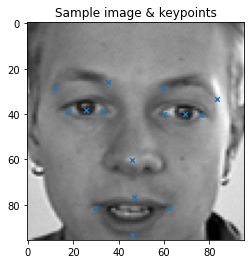

In [ ]:
def load_images(image_data):
    images = []
    for idx, sample in image_data.iterrows():
        image = np.array(sample['Image'].split(' '), dtype=int)
        image = np.reshape(image, (96,96,1))
        images.append(image)
    images = np.array(images)/255.
    return images

def load_keypoints(keypoint_data):
    keypoint_data = keypoint_data.drop('Image',axis = 1)
    keypoint_features = []
    for idx, sample_keypoints in keypoint_data.iterrows():
        keypoint_features.append(sample_keypoints)
    keypoint_features = np.array(keypoint_features, dtype = 'float')
    return keypoint_features

clean_train_images = load_images(clean_train_data)
print("Shape of clean_train_images:", np.shape(clean_train_images))
clean_train_keypoints = load_keypoints(clean_train_data)
print("Shape of clean_train_keypoints:", np.shape(clean_train_keypoints))
test_images = load_images(test_data)
print("Shape of test_images:", np.shape(test_images))
test_keypoints = load_keypoints(test_data)
print("Shape of test_keypoint:", np.shape(test_keypoints))

train_images = clean_train_images
train_keypoints = clean_train_keypoints
fig, axis = plt.subplots()
plot_sample(clean_train_images[19], clean_train_keypoints[19], axis, "Sample image & keypoints")

unclean_train_images = load_images(unclean_train_data)
print("Shape of unclean_train_images:", np.shape(unclean_train_images))
unclean_train_keypoints = load_keypoints(unclean_train_data)
print("Shape of unclean_train_keypoints:", np.shape(unclean_train_keypoints))
train_images = np.concatenate((train_images, unclean_train_images))
train_keypoints = np.concatenate((train_keypoints, unclean_train_keypoints))

#CNN simple

In [ ]:
model = Sequential()

model.add(layers.Convolution2D(32, (5, 5), padding='valid', input_shape=(96,96,1)))
model.add(layers.MaxPooling2D())
model.add(layers.Convolution2D(64, (3, 3), padding='valid', input_shape=(96,96,1)))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.1))
model.add(layers.Convolution2D(128, (3, 3), padding='valid', input_shape=(96,96,1)))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.1))
model.add(layers.Convolution2D(30, (3, 3), padding='valid', input_shape=(96,96,1)))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.1))
model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Dense(128))
model.add(layers.Dense(256))
model.add(layers.Dense(64))
model.add(layers.Dense(30))
print(model.summary())
#utils.plot_model(model, show_shapes=True, expand_nested=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 92, 92, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       7

#Train

In [ ]:

es = callbacks.EarlyStopping(monitor='loss', patience=30, verbose=1, mode='min', restore_best_weights=True)

rlp = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.001, mode='min', verbose=1)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'acc'])

history = model.fit(train_images, train_keypoints, epochs=200, batch_size=100, validation_split=0.05, callbacks=[es,rlp])

Epoch 1/200
88/88 [==============================] - 12s 36ms/step - loss: 300.9617 - mae: 11.3424 - acc: 0.4126 - val_loss: 31.0967 - val_mae: 4.2372 - val_acc: 0.5804 - lr: 0.0010
Epoch 2/200
88/88 [==============================] - 3s 30ms/step - loss: 17.4076 - mae: 3.0251 - acc: 0.4989 - val_loss: 8.5171 - val_mae: 1.9568 - val_acc: 0.5804 - lr: 0.0010
Epoch 3/200
88/88 [==============================] - 3s 29ms/step - loss: 14.5394 - mae: 2.7361 - acc: 0.5021 - val_loss: 30.1620 - val_mae: 4.6296 - val_acc: 0.5804 - lr: 0.0010
Epoch 4/200
88/88 [==============================] - 3s 30ms/step - loss: 13.0928 - mae: 2.5677 - acc: 0.5040 - val_loss: 9.3835 - val_mae: 2.0897 - val_acc: 0.5804 - lr: 0.0010
Epoch 5/200
88/88 [==============================] - 3s 30ms/step - loss: 13.0057 - mae: 2.5606 - acc: 0.5059 - val_loss: 14.5327 - val_mae: 2.9020 - val_acc: 0.5804 - lr: 0.0010
Epoch 6/200
88/88 [==============================] - 3s 31ms/step - loss: 12.3851 - mae: 2.4813 - acc: 0

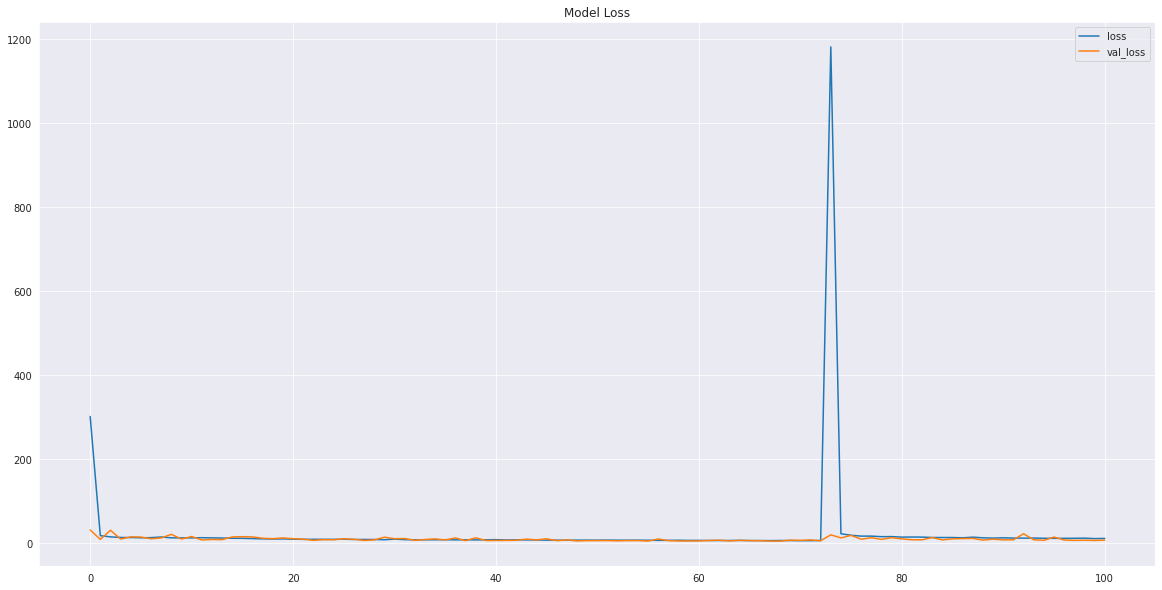

In [ ]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
df = pd.DataFrame(history.history)
df[['loss', 'val_loss']].plot(ax=ax)
ax.set_title('Model Loss', fontsize=12);

#Test

In [ ]:
test_preds = model.predict(test_images)
print("test_preds:", np.shape(test_preds))

56/56 [==============================] - 1s 7ms/step
test_preds: (1783, 30)


[ 328 1576 1586  958   50  148  678  527 1593  780 1297  491 1064  517
  421  961 1092 1304  904  846]


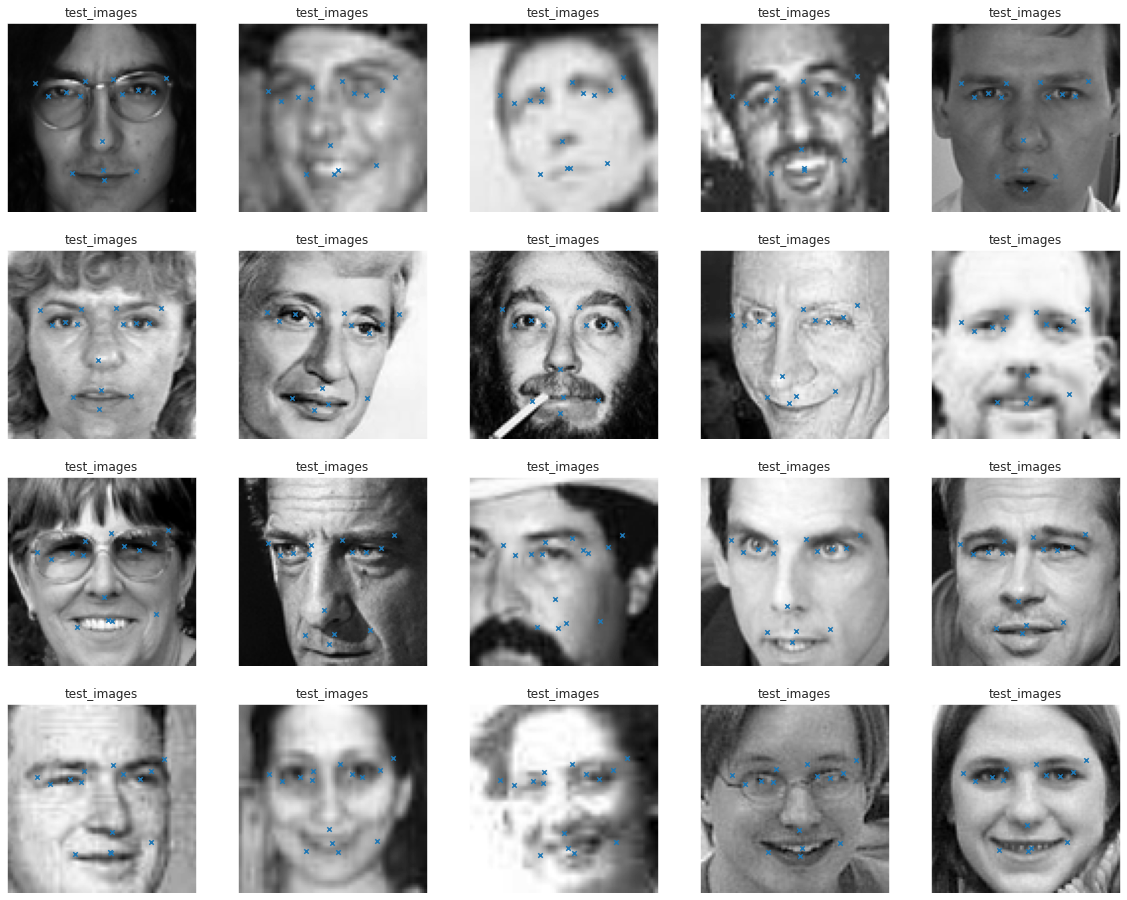

In [ ]:
fig = plt.figure(figsize=(20, 16))
idxs = np.random.choice(test_preds.shape[0], 20)
print(idxs)
for i, idx in enumerate(idxs):
    axis = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
    plot_sample(test_images[idx], test_preds[idx], axis, str("test_images"))

In [ ]:
#test_keypoint = load_keypoints(test_data)
print("test_keypoint:", np.shape(test_keypoints))
print("test_preds:", np.shape(test_preds))
#accuracy_score(test_keypoints, test_preds, normalize=True, sample_weight=None)
#dtree = DecisionTreeClassifier()
#r2_score(test_keypoints, test_preds)
#print();
#print(cross_val_score(dtree, test_keypoints, test_preds, scoring="accuracy", cv = 7))
#mean_score = cross_val_score(dtree, test_keypoints, test_preds, scoring="accuracy", cv = 7).mean()
#std_score = cross_val_score(dtree, test_keypoint, test_preds, scoring="accuracy", cv = 7).std()
#print(mean_score)
#print(std_score)

test_keypoint: (1783, 1)
test_preds: (1783, 30)


#LeNet-5 layer

In [ ]:
model = Sequential()

model.add(layers.Convolution2D(16, (3, 3), padding='valid', input_shape=(96,96,1)))
model.add(layers.MaxPooling2D())
model.add(layers.Convolution2D(32, (3, 3), padding='valid', input_shape=(96,96,1)))
model.add(layers.MaxPooling2D())
model.add(layers.Convolution2D(64, (3, 3), padding='valid', input_shape=(96,96,1)))
model.add(layers.MaxPooling2D())
model.add(layers.Convolution2D(128, (3, 3), padding='valid', input_shape=(96,96,1)))
model.add(layers.MaxPooling2D())
model.add(layers.Convolution2D(256, (3, 3), padding='valid', input_shape=(96,96,1)))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(500))
model.add(layers.Dense(500))
model.add(layers.Dense(500))
model.add(layers.Dense(500))
model.add(layers.Dense(30))
print(model.summary())
#utils.plot_model(model, show_shapes=True, expand_nested=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 94, 94, 16)        160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 47, 47, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 10, 10, 64)      

#Train

In [ ]:

es = callbacks.EarlyStopping(monitor='loss', patience=30, verbose=1, mode='min', baseline=None, restore_best_weights=True)

rlp = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-15, mode='min', verbose=1)


model.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mae','acc'])
history = model.fit(train_images, train_keypoints, epochs=200, batch_size=100, validation_split=0.05, callbacks=[es,rlp])

Epoch 1/200
88/88 [==============================] - 3s 22ms/step - loss: 694.2126 - mae: 18.4182 - acc: 0.4116 - val_loss: 78.4307 - val_mae: 6.5667 - val_acc: 0.4196 - lr: 0.0010
Epoch 2/200
88/88 [==============================] - 1s 17ms/step - loss: 47.4320 - mae: 4.9400 - acc: 0.5088 - val_loss: 10.8868 - val_mae: 2.2745 - val_acc: 0.4196 - lr: 0.0010
Epoch 3/200
88/88 [==============================] - 1s 17ms/step - loss: 11.8246 - mae: 2.3787 - acc: 0.5188 - val_loss: 6.2659 - val_mae: 1.5589 - val_acc: 0.5804 - lr: 0.0010
Epoch 4/200
88/88 [==============================] - 1s 16ms/step - loss: 10.6386 - mae: 2.2176 - acc: 0.5136 - val_loss: 6.6563 - val_mae: 1.5461 - val_acc: 0.5804 - lr: 0.0010
Epoch 5/200
88/88 [==============================] - 1s 16ms/step - loss: 10.9655 - mae: 2.2751 - acc: 0.5198 - val_loss: 6.6757 - val_mae: 1.6217 - val_acc: 0.5804 - lr: 0.0010
Epoch 6/200
88/88 [==============================] - 1s 17ms/step - loss: 10.5598 - mae: 2.2120 - acc: 0.5

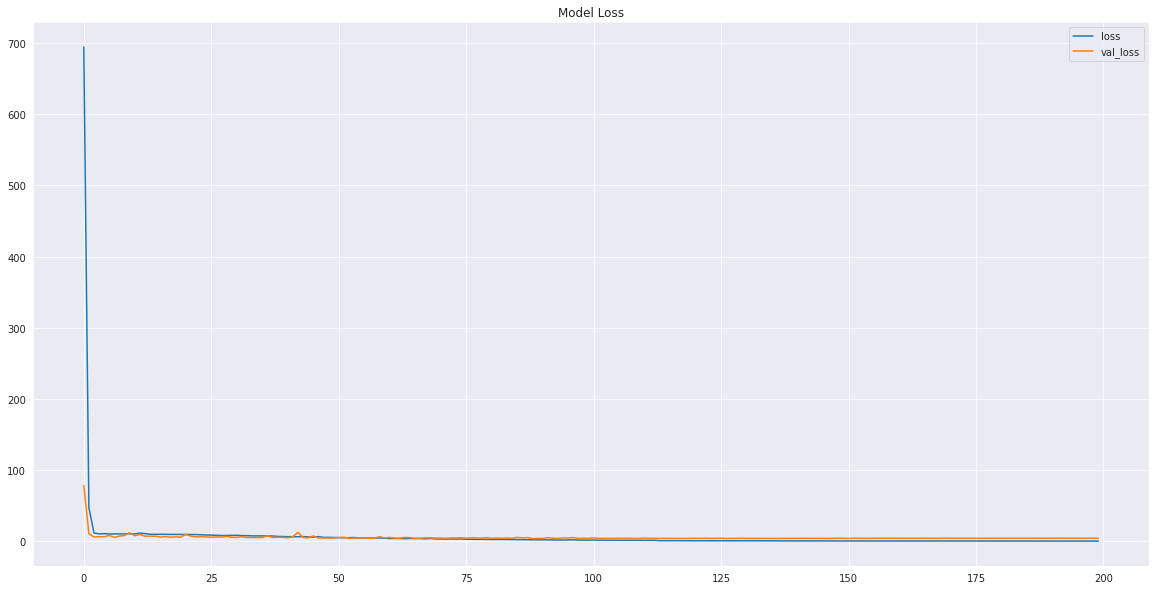

In [ ]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
df = pd.DataFrame(history.history)
df[['loss', 'val_loss']].plot(ax=ax)
ax.set_title('Model Loss', fontsize=12);

#Test

In [ ]:
test_preds = model.predict(test_images)

56/56 [==============================] - 0s 5ms/step


[1528 1070   23  929 1607   41 1264 1429 1250  925  897 1584  692 1399
  827 1104  459  709  438  488]


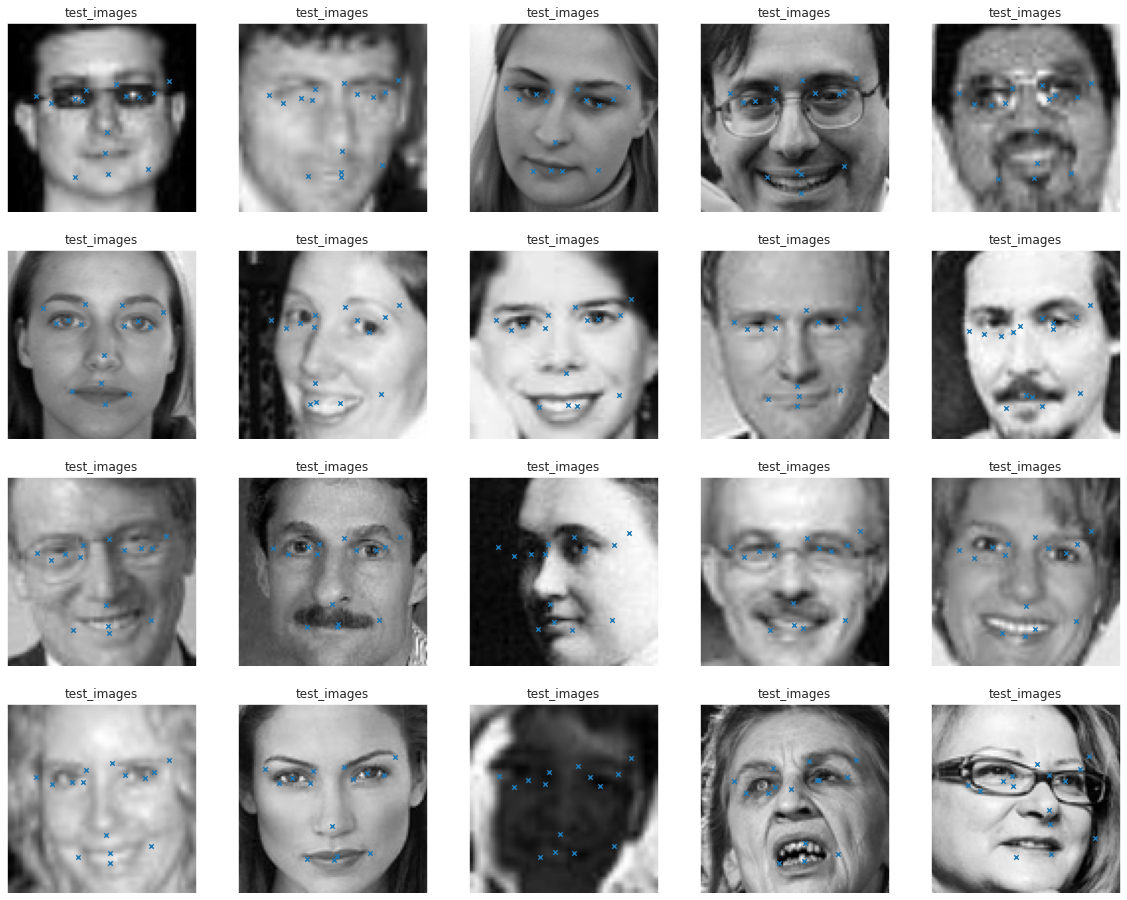

In [ ]:
fig = plt.figure(figsize=(20, 16))
idxs = np.random.choice(test_preds.shape[0], 20)
print(idxs)
for i, idx in enumerate(idxs):
    axis = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
    plot_sample(test_images[idx], test_preds[idx], axis, str("test_images"))

#LeNet with dropout

In [ ]:
model = Sequential()

model.add(layers.Convolution2D(16, (3, 3), padding='valid', input_shape=(96,96,1)))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.1))
model.add(layers.Convolution2D(32, (3, 3), padding='valid', input_shape=(96,96,1)))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.1))
model.add(layers.Convolution2D(64, (3, 3), padding='valid', input_shape=(96,96,1)))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.1))
model.add(layers.Convolution2D(128, (3, 3), padding='valid', input_shape=(96,96,1)))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.1))
model.add(layers.Convolution2D(256, (3, 3), padding='valid', input_shape=(96,96,1)))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.1))
model.add(layers.Flatten())
model.add(layers.Dense(1000))
model.add(layers.Dense(1000))
model.add(layers.Dense(1000))
model.add(layers.Dense(1000))
model.add(layers.Dense(30))
print(model.summary())
#utils.plot_model(model, show_shapes=True, expand_nested=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 94, 94, 16)        160       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 47, 47, 16)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 47, 47, 16)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 22, 22, 32)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 22, 22, 32)       

#Train

In [ ]:
es = callbacks.EarlyStopping(monitor='loss', patience=30, verbose=1, mode='min', baseline=None, restore_best_weights=True)

rlp = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-15, mode='min', verbose=1)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'acc'])

history = model.fit(train_images, train_keypoints, epochs=200, batch_size=100,validation_split=0.05, callbacks=[es, rlp])

Epoch 1/200
88/88 [==============================] - 3s 25ms/step - loss: 660.5808 - mae: 16.9808 - acc: 0.4106 - val_loss: 495.7079 - val_mae: 20.3527 - val_acc: 0.5783 - lr: 0.0010
Epoch 2/200
88/88 [==============================] - 2s 19ms/step - loss: 30.9204 - mae: 3.9118 - acc: 0.5108 - val_loss: 159.6215 - val_mae: 11.0964 - val_acc: 0.5804 - lr: 0.0010
Epoch 3/200
88/88 [==============================] - 2s 19ms/step - loss: 14.2159 - mae: 2.7041 - acc: 0.4991 - val_loss: 69.5518 - val_mae: 7.1854 - val_acc: 0.5804 - lr: 0.0010
Epoch 4/200
88/88 [==============================] - 2s 19ms/step - loss: 13.3814 - mae: 2.6087 - acc: 0.5051 - val_loss: 43.7650 - val_mae: 5.5378 - val_acc: 0.4239 - lr: 0.0010
Epoch 5/200
88/88 [==============================] - 2s 19ms/step - loss: 13.3737 - mae: 2.6106 - acc: 0.5019 - val_loss: 43.6667 - val_mae: 5.5590 - val_acc: 0.5804 - lr: 0.0010
Epoch 6/200
88/88 [==============================] - 2s 19ms/step - loss: 12.8323 - mae: 2.5422 - a

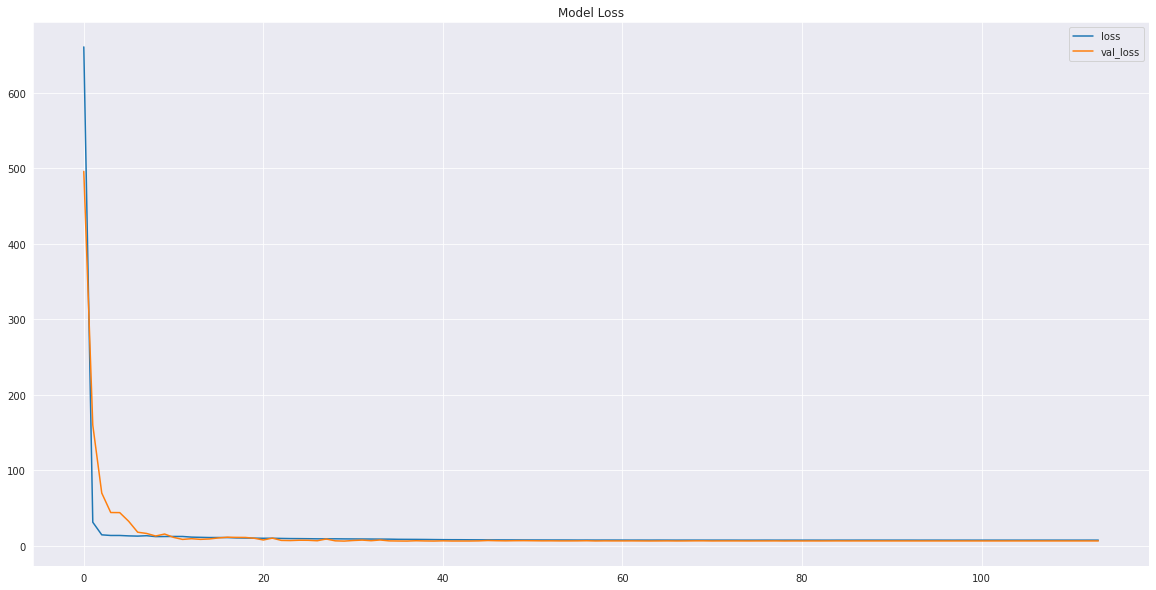

In [ ]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
df = pd.DataFrame(history.history)
df[['loss', 'val_loss']].plot(ax=ax)
ax.set_title('Model Loss', fontsize=12);

#Test

In [ ]:
test_preds = model.predict(test_images)

56/56 [==============================] - 0s 4ms/step


[ 734 1459  962  931 1181  367 1503 1383  516 1081 1182 1514    3  751
  915  216 1581  429 1065 1305]


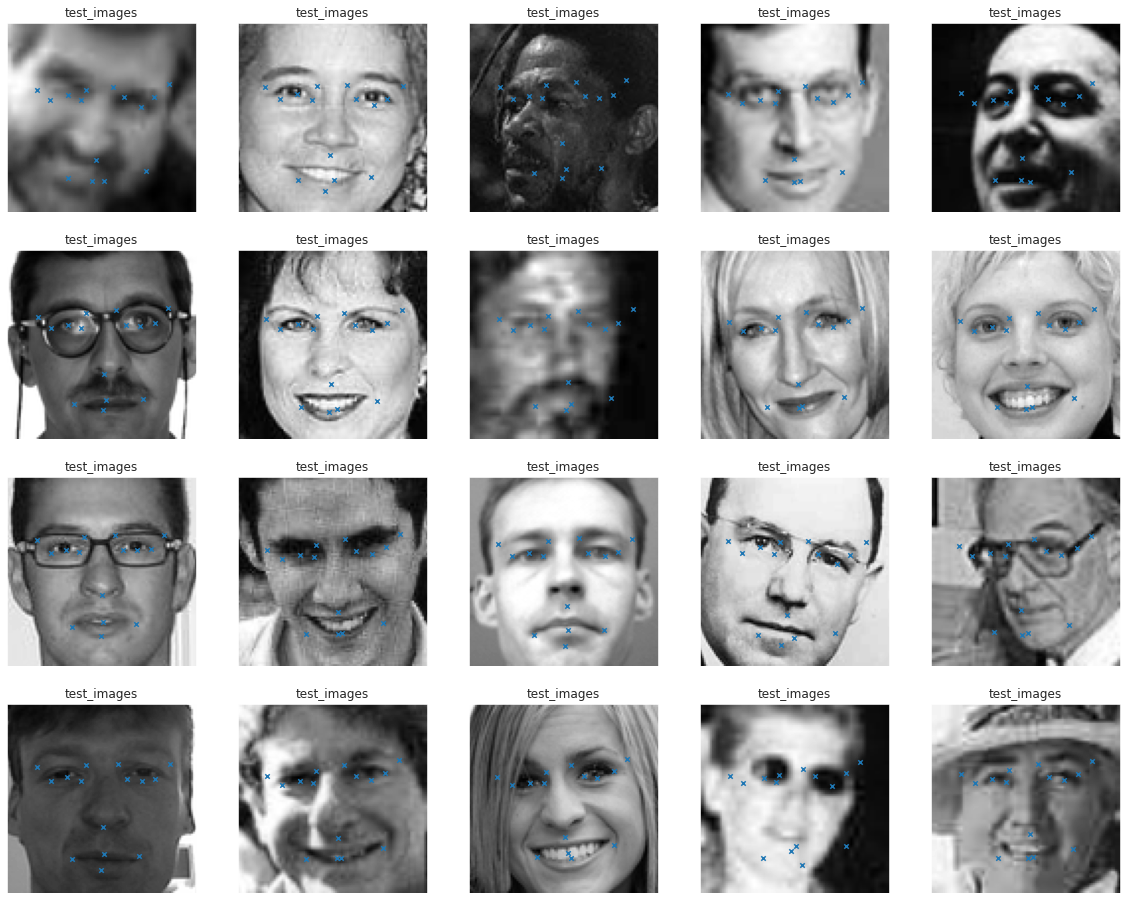

In [ ]:
fig = plt.figure(figsize=(20, 16))
idxs = np.random.choice(test_preds.shape[0], 20)
print(idxs)
for i, idx in enumerate(idxs):
    axis = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
    plot_sample(test_images[idx], test_preds[idx], axis, str("test_images"))

#Simple VGGnet

In [ ]:
model = Sequential()

model.add(layers.Convolution2D(64, (3, 3), padding='valid', input_shape=(96,96,1)))
model.add(layers.Convolution2D(64, (3, 3), padding='valid', input_shape=(96,96,1)))
model.add(layers.MaxPooling2D())
model.add(layers.Convolution2D(128, (3, 3), padding='valid', input_shape=(96,96,1)))
model.add(layers.Convolution2D(128, (3, 3), padding='valid', input_shape=(96,96,1)))
model.add(layers.MaxPooling2D())
model.add(layers.Convolution2D(256, (3, 3), padding='valid', input_shape=(96,96,1)))
model.add(layers.Convolution2D(256, (3, 3), padding='valid', input_shape=(96,96,1)))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(512))
model.add(layers.Dense(512))
model.add(layers.Dense(512))
model.add(layers.Dense(512))
model.add(layers.Dense(30))
print(model.summary())
#utils.plot_model(model, show_shapes=True, expand_nested=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 94, 94, 64)        640       
                                                                 
 conv2d_15 (Conv2D)          (None, 92, 92, 64)        36928     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 46, 46, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 44, 44, 128)       73856     
                                                                 
 conv2d_17 (Conv2D)          (None, 42, 42, 128)       147584    
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 21, 21, 128)      0         
 g2D)                                                 

#Train

In [ ]:
es = callbacks.EarlyStopping(monitor='loss', patience=30, verbose=1, mode='min', baseline=None, restore_best_weights=True)

rlp = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-15, mode='min', verbose=1)


model.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mae','acc'])

history = model.fit(train_images, train_keypoints, epochs=200, batch_size=100,validation_split=0.05, callbacks=[es, rlp])

Epoch 1/200
88/88 [==============================] - 17s 159ms/step - loss: 1415.7499 - mae: 15.9531 - acc: 0.3266 - val_loss: 11.5210 - val_mae: 2.4374 - val_acc: 0.4174 - lr: 0.0010
Epoch 2/200
88/88 [==============================] - 12s 140ms/step - loss: 13.4557 - mae: 2.6091 - acc: 0.5320 - val_loss: 8.0911 - val_mae: 1.8736 - val_acc: 0.5261 - lr: 0.0010
Epoch 3/200
88/88 [==============================] - 12s 141ms/step - loss: 11.6256 - mae: 2.4003 - acc: 0.5713 - val_loss: 6.4302 - val_mae: 1.6278 - val_acc: 0.5348 - lr: 0.0010
Epoch 4/200
88/88 [==============================] - 12s 141ms/step - loss: 14.2441 - mae: 2.7293 - acc: 0.6082 - val_loss: 8.2800 - val_mae: 1.8959 - val_acc: 0.4978 - lr: 0.0010
Epoch 5/200
88/88 [==============================] - 12s 140ms/step - loss: 9.7133 - mae: 2.1469 - acc: 0.6160 - val_loss: 6.6882 - val_mae: 1.6452 - val_acc: 0.5304 - lr: 0.0010
Epoch 6/200
88/88 [==============================] - 12s 139ms/step - loss: 9.3413 - mae: 2.1176 

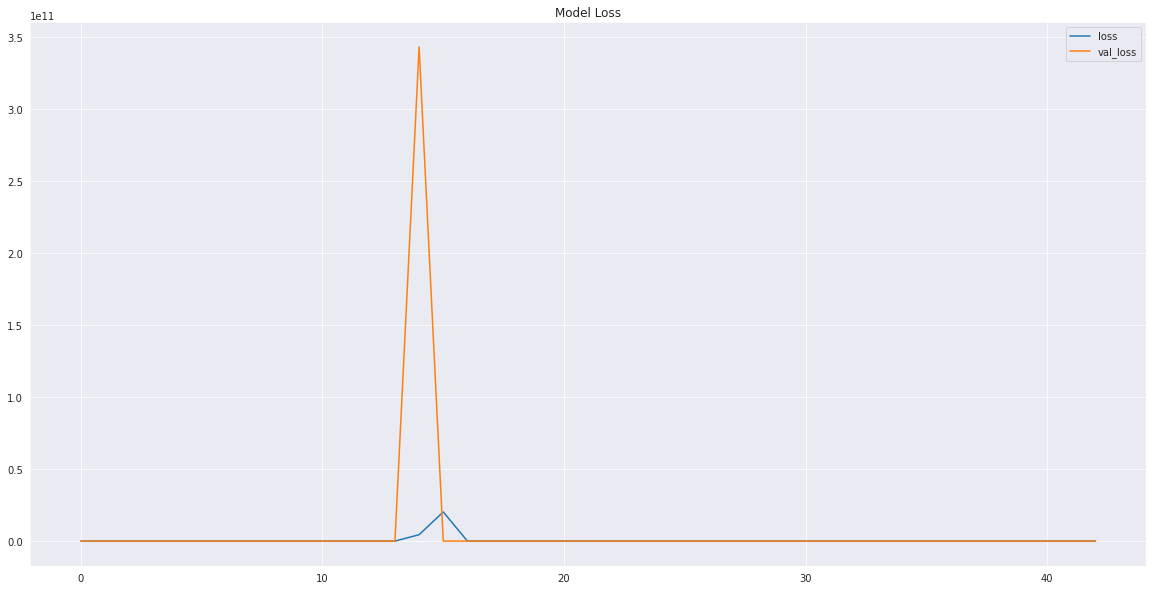

In [ ]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
df = pd.DataFrame(history.history)
df[['loss', 'val_loss']].plot(ax=ax)
ax.set_title('Model Loss', fontsize=12);

#Test

In [ ]:

test_preds = model.predict(test_images)
a = test_preds[:, 22:24]
b = test_preds[:, 24:26]
mouth_length = np.linalg.norm(a-b, axis=1)
a = test_preds[:, 26:28]
b = test_preds[:, 28:30]
mouth_width = np.linalg.norm(a-b, axis=1)
proportions = np.abs(mouth_width/mouth_length)

56/56 [==============================] - 2s 22ms/step


[ 686 1629 1282  569 1150  114 1726  644  610 1489  832  689 1012 1595
  868  801  730 1347 1423  904]


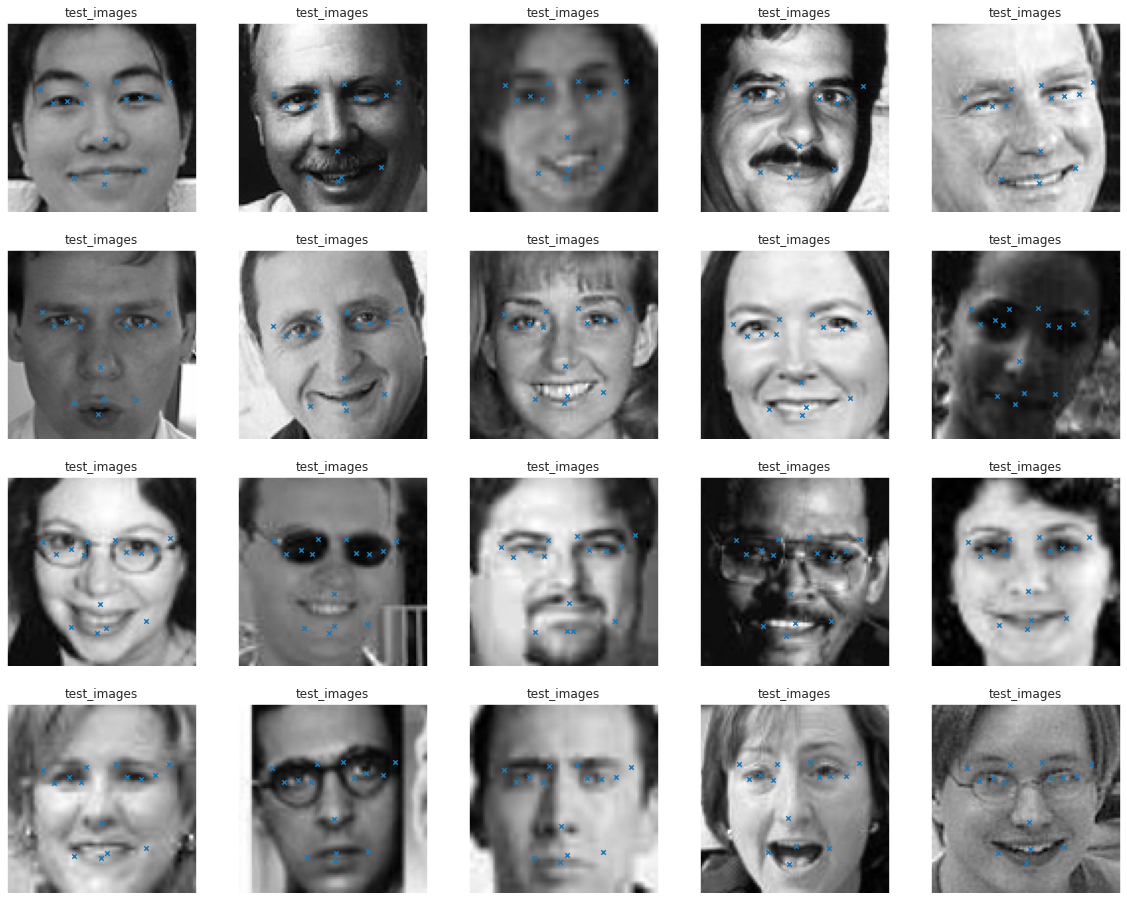

In [ ]:
fig = plt.figure(figsize=(20, 16))
idxs = np.random.choice(test_preds.shape[0], 20)
print(idxs)
for i, idx in enumerate(idxs):
    axis = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
    plot_sample(test_images[idx], test_preds[idx], axis, str("test_images"))